# Cuantificación de Incertidumbre (UQ)

**Objetivo**

El objetivo de este pipeline es cuantificar, analizar y operacionalizar la incertidumbre predictiva de un sistema de soporte a la decisión clínica multiclase, combinando:

- Calibración probabilística (¿son fiables las probabilidades?)
- Incertidumbre aleatórica (entropía)
- Predicción conforme multiclase (garantías estadísticas)
- Integración clínica mediante reglas de derivación

Este enfoque sigue las recomendaciones de la literatura moderna en trustworthy AI y interpretable machine learning [1][2][3].

## Configuración del entorno

En esta sección prentendo dejar el entorno configurado para trabajar posteriormente.

Cargo las librerías a usar y  realizo configuraciones generales.

In [ ]:
# Instalación de dependencias
# !pip install mapie --quiet

In [1]:
# Bibliotecas estándar
import numpy as np
import pandas as pd
import os
import json
import joblib
import glob
import warnings
import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.base import BaseEstimator, ClassifierMixin

from mapie.classification import SplitConformalClassifier, RAPSConformityScore
from mapie.metrics.classification import (
    classification_coverage_score,
    classification_mean_width_score
)

# Google Colab (descomentar si se usa en Colab)
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Realizo configuraciones globales
warnings.filterwarnings('ignore')

Defino variables globales.

In [3]:
# Configuro la semilla para reproducibilidad, requisito fundamental según TRIPOD-AI (ítem 14) [TRIPOD] y el AI Act [AI Act] para sistemas de alto riesgo
RANDOM_STATE = 1976

# Defino las rutas a los ficheros
# Configuro la ruta de los datos.
DRIVE_PATH = 'D:\\Desarrollo\\TFG\\Procesado\\' # Local
# DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/TFG/Dataset/Procesado/' # Google Drive

# Configuro las rutas para guardar modelos y resultados
MODELS_PATH = os.path.join(DRIVE_PATH, 'modelos')
RESULTS_PATH = os.path.join(DRIVE_PATH, 'resultados')
FIGURES_PATH = os.path.join(DRIVE_PATH, 'figuras')
XAI_PATH = os.path.join(RESULTS_PATH, 'xai')

for path in [MODELS_PATH, RESULTS_PATH, FIGURES_PATH, XAI_PATH]:
    os.makedirs(path, exist_ok=True)

# Defino los ficheros de datos
X_TRAIN_FILE = os.path.join(DRIVE_PATH, 'X_train_selected.csv')
X_CAL_FILE = os.path.join(DRIVE_PATH, 'X_cal_selected.csv')
X_TEST_FILE = os.path.join(DRIVE_PATH, 'X_test_selected.csv')
Y_TRAIN_FILE = os.path.join(DRIVE_PATH, 'y_train.csv')
Y_CAL_FILE = os.path.join(DRIVE_PATH, 'y_cal.csv')
Y_TEST_FILE = os.path.join(DRIVE_PATH, 'y_test.csv')
ENCODERS_FILE = os.path.join(DRIVE_PATH, 'encoders_mapping.json')

Creo una función para mostrar logs

In [4]:
def log(mensaje):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {mensaje}")

### Carga de datos y modelo

Se cargan desde disco el modelo para trabajar con él.

In [5]:
# Cargo los datos
X_train = pd.read_csv(X_TRAIN_FILE)
X_cal = pd.read_csv(X_CAL_FILE)
X_test = pd.read_csv(X_TEST_FILE)
y_train = pd.read_csv(Y_TRAIN_FILE).squeeze()
y_cal = pd.read_csv(Y_CAL_FILE).squeeze()
y_test = pd.read_csv(Y_TEST_FILE).squeeze()

with open(ENCODERS_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)
CLASS_NAMES = {int(k): v for k, v in data['cardiopatia'].items()
                if v != 'No se puede determinar'}
RACE_ETHNICITY = {int(k): v for k, v in data['race_ethnicity'].items()}

TARGET_LABEL_NAME = "Estenosis"
TARGET_CLASS_IDX = next(k for k, v in CLASS_NAMES.items() if v == TARGET_LABEL_NAME)
TARGET_SAFE_CLASS_NAME = 'Ninguna'
SAFE_CLASS_IDX = next(k for k, v in CLASS_NAMES.items() if v == TARGET_SAFE_CLASS_NAME)

# Defino constantes globales
N_CLASSES = len(CLASS_NAMES)
FEATURE_NAMES = X_train.columns.tolist()

# Defino las variables categóricas, aunque sean codificadas como números
CATEGORICAL_FEATURES = ['sex_encoded', 'race_ethnicity_encoded']
CATEGORICAL_INDEXES = [FEATURE_NAMES.index(col) for col in CATEGORICAL_FEATURES if col in FEATURE_NAMES]

In [6]:
# Cargo el modelo final
SELECTED_MODEL = 'catboost'
FINAL_MODEL_PATH = os.path.join(MODELS_PATH, f'{SELECTED_MODEL}_*.joblib')
model_files = glob.glob(os.path.join(MODELS_PATH, f'{SELECTED_MODEL}_*.joblib'))
if not model_files:
    raise FileNotFoundError(f"No se encontró el modelo final {FINAL_MODEL_PATH}.")

model_files.sort(reverse=True)
model_file = model_files[0]
meta_file = model_file.replace('.joblib', '_meta.json')

FINAL_MODEL = joblib.load(model_file)

print(f'MODELO PARA ANÁLISIS UQ')
print(f'Tipo: {type(FINAL_MODEL).__name__}')
print(f'Features: {len(FEATURE_NAMES)}')
print(f'Clases: {N_CLASSES} ({", ".join(CLASS_NAMES.values())})')

MODELO PARA ANÁLISIS UQ
Tipo: CatBoostClassifier
Features: 48
Clases: 4 (Ambas, Estenosis, Insuficiencia, Ninguna)


## Predicción Conforme (MAPIE, multiclase)

**Justificación**

La predicción conforme proporciona garantías estadísticas de cobertura independientes del modelo, siendo especialmente adecuada para sistemas de alto riesgo [3,4].

En multiclase, el método LAC (Least Ambiguous Classifier) minimiza el tamaño de los conjuntos de predicción.

Cobertura empírica (95%): 0.9450
Tamaño medio del set conforme: 2.75


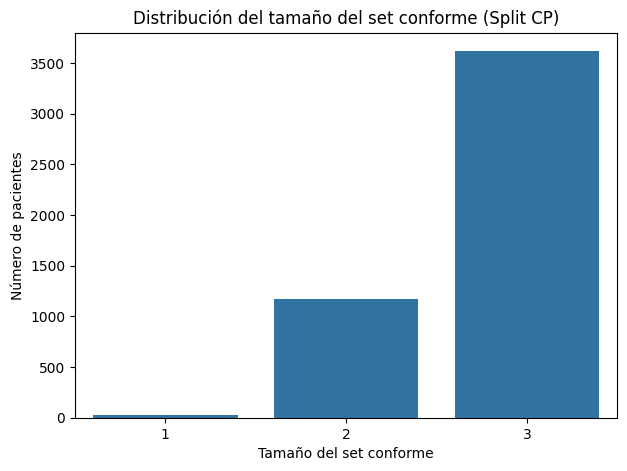

In [7]:
# Hago un análisis de Conformal Prediction (CP) usando MAPIE.

# Creo un wrapper adaptado a CastBoost, pues al cargar los datos de un fichero, las características no se reconocen automáticamente.
class CatBoostWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, n_features):
        self.model = model
        self.n_features_in_ = n_features
        self.classes_ = model.classes_
        self.feature_names_ = model.feature_names_
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        return self.model.predict(X).flatten()
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
wrapped_model = CatBoostWrapper(FINAL_MODEL, n_features=48)

# Defino la función de conformidad
conformity_score = RAPSConformityScore()

# Inicializo el clasificador conforme
alpha = 0.20  # 80% de garantía (con fines ilustrativos para el TFG)
cp = SplitConformalClassifier(
    estimator=wrapped_model,
    conformity_score=conformity_score,
    confidence_level=1 - alpha, 
    prefit=True
)

cp.conformalize(X_cal, y_cal)

# predict() sin alpha
y_pred_cp, y_ps_cp = cp.predict_set(X_test)
set_sizes = y_ps_cp[:, :, 0].sum(axis=1)

# Calulo las métricas de CP
coverage = classification_coverage_score(y_test, y_ps_cp)
mean_width = classification_mean_width_score(y_ps_cp)

print(f"Cobertura empírica (95%): {coverage.item():.4f}")
print(f"Tamaño medio del set conforme: {mean_width.item():.2f}")

plt.figure(figsize=(7, 5))
sns.countplot(x=set_sizes)
plt.xlabel("Tamaño del set conforme")
plt.ylabel("Número de pacientes")
plt.title("Distribución del tamaño del set conforme (Split CP)")
plt.show()
plt.close()

In [8]:
# Realizo la validación de Cobertura Condicional (Estenosis)
mask_estenosis = (y_test == TARGET_CLASS_IDX)
n_estenosis = mask_estenosis.sum()

if n_estenosis > 0:
    # Calculo la cobertura solo para este subgrupo
    sets_estenosis = y_ps_cp[mask_estenosis]
    
    covered_estenosis = sets_estenosis[TARGET_CLASS_IDX] 
 
    coverage_estenosis = covered_estenosis.mean()
    
    print(f"Total muestras reales de {TARGET_LABEL_NAME}: {n_estenosis}")
    print(f"Cobertura Global Esperada (1-alpha): {(1-alpha):.2f}")
    print(f"Cobertura Real en {TARGET_LABEL_NAME}: {coverage_estenosis:.4f}")
    
    if coverage_estenosis < (1-alpha - 0.05):
        print("ALERTA: La cobertura en la clase minoritaria es significativamente baja.")
    else:
        print("ROBUSTEZ: El modelo mantiene las garantías de cobertura en la clase crítica.")
else:
    print("No hay muestras de Estenosis en el test set para validar.")

Total muestras reales de Estenosis: 94
Cobertura Global Esperada (1-alpha): 0.80
Cobertura Real en Estenosis: 0.7500
ROBUSTEZ: El modelo mantiene las garantías de cobertura en la clase crítica.


## Integración clínica (Semáforo)

**Justificación**

La incertidumbre solo es útil si modifica decisiones clínicas.

Se propone un sistema de derivación que combina:
- Incertidumbre aleatórica (entropía)
- Ambigüedad conforme (tamaño del set)

In [11]:
results_uq = pd.DataFrame({
    "Paciente_ID": X_test.index,
    "Etnia": X_test["race_ethnicity_encoded"].map(RACE_ETHNICITY),
    "Clase_Real": y_test.map(CLASS_NAMES),
    "Set_Size": set_sizes
})

def clinical_action(row):
    if row["Set_Size"] == 0:
        return "REVISIÓN (Set vacío)"
    if row["Set_Size"] > 1:
        return "REVISIÓN (Ambigüedad)"
    return "AUTOMÁTICO"

results_uq["Accion_Clinica"] = results_uq.apply(clinical_action, axis=1)

print(f"Resumen de Acciones Clínicas Sugeridas:")
print(results_uq["Accion_Clinica"].value_counts())

Resumen de Acciones Clínicas Sugeridas:
Accion_Clinica
REVISIÓN (Ambigüedad)    4788
AUTOMÁTICO                 27
Name: count, dtype: int64


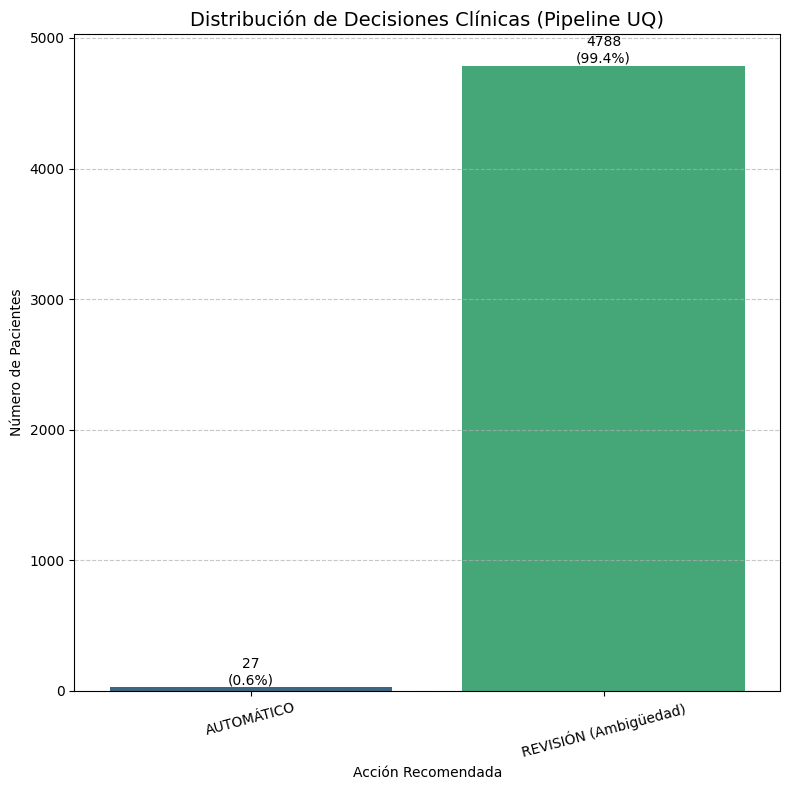

CONCLUSIÓN: El sistema permite diagnosticar automáticamente al 0.6% de los pacientes con garantías estadísticas.


In [12]:
# Creo un gráfico para las acciones clínicas
actions_order = [
    "AUTOMÁTICO", 
    "REVISIÓN (Ambigüedad)", 
    "REVISIÓN (Alta incertidumbre)", 
    "REVISIÓN (Set vacío)"
]

plt.figure(figsize=(8, 8))
ax = sns.countplot(
    data=results_uq, 
    x="Accion_Clinica", 
    order=[x for x in actions_order if x in results_uq["Accion_Clinica"].unique()],
    palette="viridis"
)

# Añado las etiquetas de porcentaje encima de las barras
total = len(results_uq)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.annotate(f'{int(height)}\n({percentage})',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', 
                fontsize=10, color='black')

plt.title("Distribución de Decisiones Clínicas (Pipeline UQ)", fontsize=14)
plt.ylabel("Número de Pacientes")
plt.xlabel("Acción Recomendada")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
plt.close()

# Imprimo la métrica de automatización
automatized = results_uq[results_uq["Accion_Clinica"] == "AUTOMÁTICO"].shape[0]
print(f"CONCLUSIÓN: El sistema permite diagnosticar automáticamente al {automatized/total*100:.1f}% de los pacientes con garantías estadísticas.")

# Bibliografía

[1] Molnar C. Interpretable Machine Learning. 2nd ed. 2023.

[2] Shannon CE. A mathematical theory of communication. Bell Syst Tech J. 1948;27:379–423.

[3] Angelopoulos AN, Bates S. A gentle introduction to conformal prediction and distribution-free uncertainty quantification. arXiv:2107.07511. 2021.

[4] Guo C, Pleiss G, Sun Y, Weinberger KQ. On calibration of modern neural networks. ICML. 2017.